# Machine Learning Pipeline - Interpretation

Check the python kernel we are using, should be the local one, not the one in the virtual environment

In [1]:
import sys
print(sys.executable)

/usr/bin/python3


## Import libraries

In [2]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import rpy2.robjects as ro
import xgboost as xgb
import shap
import warnings
import math
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from skopt import BayesSearchCV
from sklearn.feature_selection import SelectFromModel

## Define Variables

In [3]:
%store -r X_train_reduced
%store -r X_test_reduced
%store -r y_train
%store -r y_test
%store -r bin_train
%store -r bin_test
%store -r model_fs

In [4]:
bin_train = bin_train.squeeze()

In [5]:
y_train = pd.Series(y_train)

In [6]:
predictions_array = model_fs.predict(X_train_reduced)
predictions_array = pd.Series(predictions_array, index = bin_train.index)

In [7]:
deltas = np.abs(y_train - predictions_array).astype(float)

In [8]:
rownames = ["bin", "observed", "predicted", "residual"]

In [9]:
errors_df = pd.DataFrame([bin_train, y_train, predictions_array, deltas], index = rownames).transpose()
errors_df["idx"] = errors_df.index; errors_df = errors_df.astype({"residual":float})

## Feature Interpretation

In [10]:
backbone = pd.read_csv(filepath_or_buffer= "/home/ieo7429/Desktop/THESIS_GAB/tables/backbone_1Mbp.tsv", sep = "\t", header = 0)

In [11]:
errors_df_with_coords = pd.merge(left = backbone, right = errors_df, how = "inner", on = "bin")

In [12]:
top10_worst_predictions = errors_df_with_coords.nlargest(10, "residual")

In [13]:
top10_worst_predictions

,chr,start,end,bin,observed,predicted,residual,idx
1341,chr19,22048093,23050278,19_23,-1.254008,-0.301871,0.952138,842
865,chr9,121183074,122184586,9_122,-0.613145,0.142661,0.755806,1984
1082,chr12,78499591,79505995,12_79,1.184221,0.481226,0.702995,501
1129,chr14,43140439,44143704,14_44,1.38515,0.69685,0.688300,548
673,chr7,67058425,68059296,7_68,-0.750977,-0.072969,0.678008,1809
504,chr5,15076261,16081344,5_16,0.91359,0.270516,0.643073,1565
497,chr4,188151717,189152523,4_189,-0.979604,-0.352682,0.626922,1436
268,chr3,2000227,3000339,3_3,-0.780147,-0.182756,0.597392,1284
1016,chr11,103004945,104004992,11_104,1.080942,0.485108,0.595834,311
321,chr3,95010736,96010848,3_96,1.327609,0.745272,0.582337,1341


In [14]:
explainer = shap.TreeExplainer(model_fs, approximate= False)
shap_values = explainer(X_train_reduced)

In [29]:
original_idx = y_train.index.get_loc("1984")

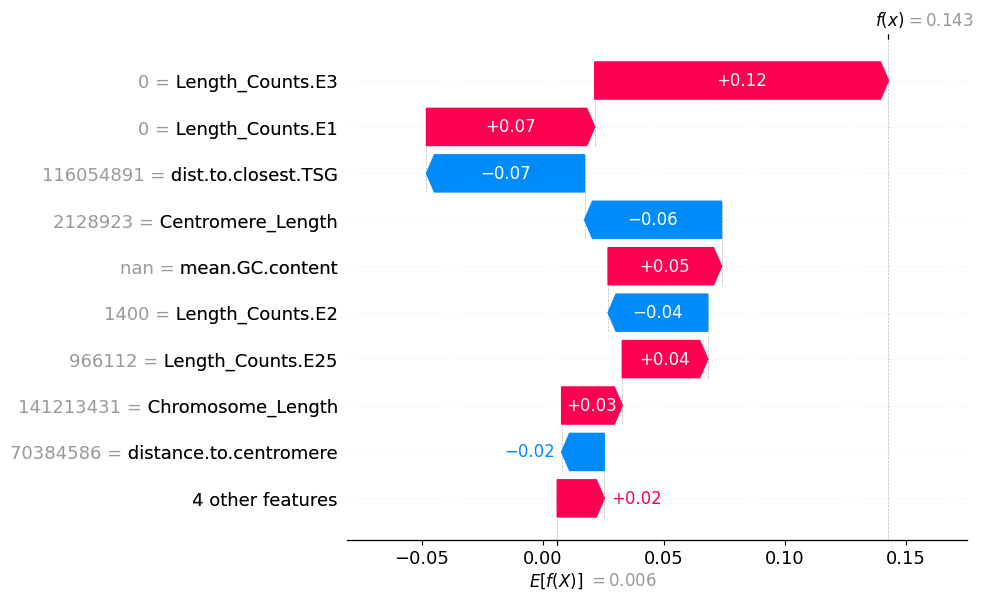

In [30]:
shap.plots.waterfall(shap_values[original_idx])

In [17]:
shap_vals_df = pd.DataFrame(shap_values.values, columns= X_train_reduced.columns)

In [18]:
cols_idxs = np.argmax(shap_vals_df, axis = 1)

In [31]:
cols_occurrences = pd.Series(X_train_reduced.columns[cols_idxs], index= bin_train.index, name= "Annotation")

In [32]:
annot_with_bins = pd.concat([bin_train, cols_occurrences], axis = 1)

In [33]:
annot_with_coords = pd.merge(left = annot_with_bins, right = backbone, how = "inner", on = "bin")
annot_with_coords = pd.merge(left = annot_with_coords, right = errors_df[["bin","predicted"]], how = "inner", on = "bin")
annot_with_coords = annot_with_coords[["bin", "chr", "start", "end", "Annotation", "predicted"]]

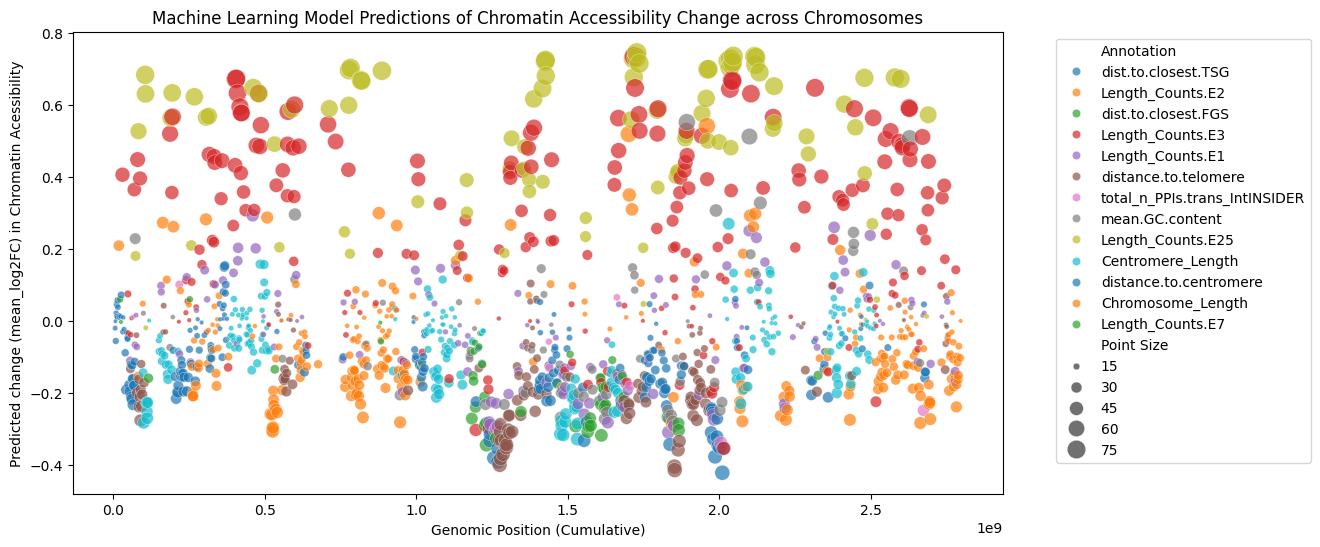

In [37]:
df = annot_with_coords

df["midpoint"] = (df["start"] + df["end"]) / 2

df.sort_values(["chr", "start"], inplace=True)

chr_offsets = {chrom: offset for chrom, offset in zip(df["chr"].unique(), np.cumsum([0] + list(df.groupby("chr")["end"].max()[:-1])))}
df["cumulative_midpoint"] = df["midpoint"] + df["chr"].map(chr_offsets)

df["Point Size"] = (df["predicted"].abs() * 100) + 10

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df,
    x="cumulative_midpoint",
    y="predicted",
    hue="Annotation",
    size="Point Size",
    sizes=(10, 200),
    palette="tab10",
    alpha=0.7
)

plt.xlabel("Genomic Position (Cumulative)")
plt.ylabel("Predicted change (mean_log2FC) in Chromatin Acessibility")
plt.title("Machine Learning Model Predictions of Chromatin Accessibility Change across Chromosomes")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()